<a href="https://colab.research.google.com/github/victory256/Sample-ML-Repo/blob/hw6/%D0%AF%D0%BA%D1%83%D0%B1%D0%BE%D0%B2%D0%B0_hw06_linear_regression_inclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задач лекции
# ML T-Generation Занятие 3: Линейная регрессия.
# Проблема переобучения. Кросс-валидация и регуляризация.



## 2. Приближение одномерной функции многочленом

Начнем с простой задачи.


1) Есть функция $f(x)$, но мы ее не знаем.

2) Зато мы знаем ее значения в $m$ точках (они называются тренировочным множеством):
$$f(x_1) = y_1$$
$$\cdots$$
$$f(x_m) = y_m$$
3) Нужно научиться приблизительно восстанавливать эту функцию.

Самый простой способ - научиться приближать её многочленом, а именно давайте подберем такие коэффициенты $a_0, a_1, \ldots, a_n$, чтобы многочлен $P(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$ был как можно ближе к $f(x)$.

Но что такое "приблизить"? Мы знаем лишь значения в $m$ точках, так что в лучшем случае она должна проходить через все эти точки (хотя скоро мы увидим, что это не так).

В этом случае обычно пытаются минимизировать сумму квадратов ошибок во всех точках, то есть **функцию потерь** $$Q(P) = \sum_i (P(x_i) - f(x_i))^2 $$

Эту величину называют **MSE** - Mean Squared Error (средняя квадратичная ошибка).

Тут может возникнуть вопрос, почему мы берем именно сумму квадратов, а не, например, сумму модулей. Однозначного ответа на этот вопрос нет, наиболее удачный ответ, пожалуй такой: у суммы квадратов есть много удобных свойств, например это выпуклая, дифференцируемая функция. Тем не менее иногда другой выбор может быть оправданным. Если вам интересно чуть больше понять про смысл этих условий, можете решить такие задачи:

**(0.5 балла) Доп. Задача 1.** Найдите число m такое, что для заданных $x_i$ сумма $\sum|m - x_i|$ минимальна

Найдем производную и приравняем к нулю $(\sum|m - x_i|)'=0 \Rightarrow \sum sign(m - x_i)=0 \Rightarrow  \begin{cases}
   x_{n/2} &\text{ $n$ не четное}\\
   1/2 \cdot(x_{n/2}+x_{1+n/2}) &\text{$n$ четное}
 \end{cases} \Rightarrow m= \text{медиана}$

**(0.5 балла) Доп. Задача 2.** Найдите число m такое, что для заданных $x_i$ сумма $\sum(m - x_i)^2$ минимальна


Найдем производную и приравняем к нулю $(\sum(m - x_i)^2)'=0 \Rightarrow -2 \cdot (\sum(m - x_i))=0 \Rightarrow \sum(m - x_i)=0 \Rightarrow n \cdot m - \sum x_i=0 \Rightarrow m = \frac{1}{n} \sum x_i \Rightarrow$
$ m= \text{среднее арифметическое}$



Сначала просто нарисуем какой-нибудь многочлен, например $f(x) = 3x^3 - 2x^2 + x$ на отрезке $[-1, 1]$:

In [58]:
def f(x):
    return 3 * x ** 3 - 2 * x**2 + x

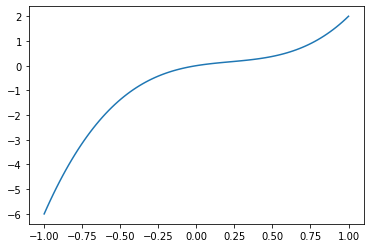

In [59]:
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
x100 = np.linspace(-1, 1, 100)
plt.plot(x100, f(x100))
plt.show()

Теперь зададим набор точек (10 штук) и посмотрим что будет, если подобрать по ним коэффициенты нашего многочлена:

In [60]:
x = np.linspace(-1, 1, 10)  # 10 точек на отрезке [-1, 1]
y = f(x)
coefs = np.polyfit(x, y, deg = 2)
coefs

array([-2.00000000e+00,  3.17037037e+00, -8.42600032e-16])

(это означает многочлен $-2x^2 + 3.17037 x$)

numpy позволяет легко работать с многочленами, заданными их коэффициентами. Мы можем создать из них объект poly1d, который можно будет просто вызывать для получения нужных значений:

In [61]:
poly = np.poly1d(coefs)
poly(0), poly(1), poly(2)

(-8.426000324584082e-16, 1.1703703703703712, -1.6592592592592563)

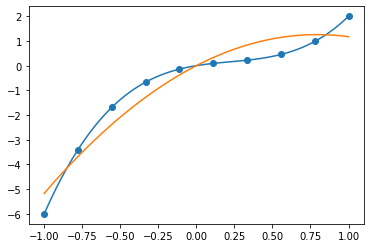

In [62]:
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

Довольно ожидаемо, наша функция (оранжевая) не очень похожа на то, что мы искали (синяя). Наверное зря мы пытаемся приблизить кубическую функцию многочленом второй степени. Давайте попробуем 3-ю степень.

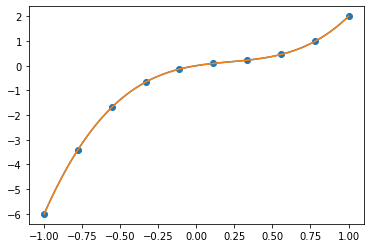

In [63]:
coefs = np.polyfit(x, y, deg = 3)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

На этот раз мы в точности угадали функцию. Можете проверить, что если увеличивать степень многочлена, результат не меняется: более высокие степени тут просто не нужны.

Но мы сейчас жили в идеальном мире. На практике чаще всего известные нам значения не совсем точны. Давайте добавим к значениям нашей функции немного шума:

In [64]:
def f_real(x):
    return 3 * x ** 3 - 2 * x**2 + x + np.random.normal(0, 1, x.shape)

In [65]:
x.shape

(10,)

In [66]:
x = np.linspace(-1, 1, 10)
y = f_real(x) # + np.random.normal(0, 0.5, 10)  # случайный шум

In [67]:
x100 = np.linspace(-1, 1, 100)

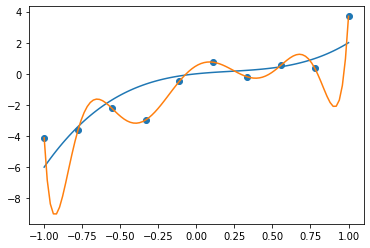

In [68]:
coefs = np.polyfit(x, y, deg = 10)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))
plt.show()

Теперь мы почти попали. Перед тем как читать дальше, подумайте над заданием.

**(1 балл) Обязательное задание 1:** попробуйте увеличить степень полинома. Что произойдет с графиком нашего приближения? Посмотрите  как обе функции себя ведут вне интервала x. Попробуйте сформулировать проблему, с которой мы столкнулись.

Посмотрим на графики для степеней 15, 20, 25 в интервале [ -1.05 ; 1.05 ]
Видим, что на тестовом интервале [ -1.0 ; 1.0 ] полином степеней больше 10 проходит точь в точь по точкам. А за его пределами уходит очень далеко от исходного синего полинома. Это видно даже на 0,05 шаге от исходного тестового отрезка (левый рисунок). Если смотреть больший отрезок, то отличия будут на порядок (правый рисунок). Значит увеличение степени многочлена приводит нашу модель к переобучению.

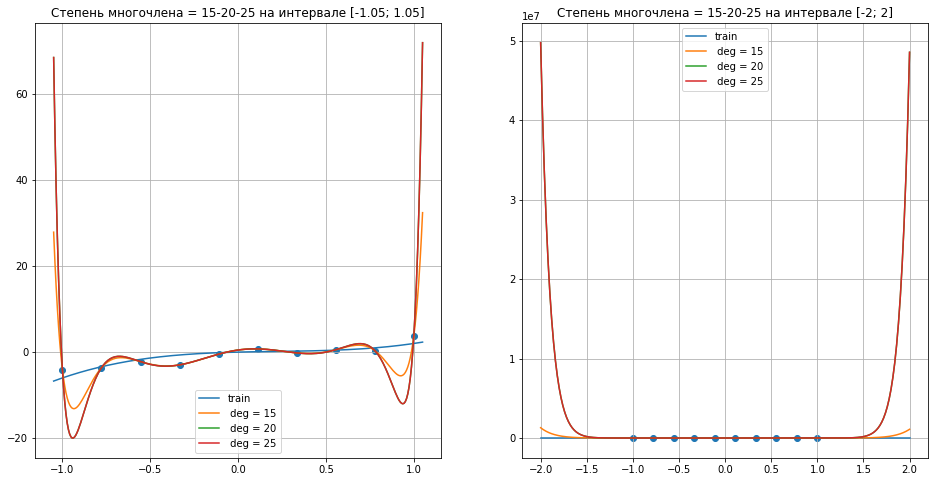

In [69]:
x300 = np.linspace(-1.05, 1.05, 300)
x400 = np.linspace(-2, 2, 400)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
coefs_15 = np.polyfit(x, y, deg = 15)
poly_15 = np.poly1d(coefs_15)
plt.scatter(x, y)
plt.plot(x300, f(x300),label='train')
plt.plot(x300, poly_15(x300),label=' deg = 15')
coefs_20 = np.polyfit(x, y, deg = 20)
poly_20 = np.poly1d(coefs_20)
plt.plot(x300, poly_20(x300),label=' deg = 20')
coefs_25 = np.polyfit(x, y, deg = 20)
poly_25 = np.poly1d(coefs_25)
plt.plot(x300, poly_25(x300),label=' deg = 25')
plt.legend()
plt.grid()
plt.title("Степень многочлена = 15-20-25 на интервале [-1.05; 1.05]")
plt.subplot(1, 2, 2)
coefs_15 = np.polyfit(x, y, deg = 15)
poly_15 = np.poly1d(coefs_15)
plt.scatter(x, y)
plt.plot(x400, f(x400),label='train')
plt.plot(x400, poly_15(x400),label=' deg = 15')
coefs_20 = np.polyfit(x, y, deg = 20)
poly_20 = np.poly1d(coefs_20)
plt.plot(x400, poly_20(x400),label=' deg = 20')
coefs_25 = np.polyfit(x, y, deg = 20)
poly_25 = np.poly1d(coefs_25)
plt.plot(x400, poly_25(x400),label=' deg = 25')
plt.legend()
plt.grid()
plt.title("Степень многочлена = 15-20-25 на интервале [-2; 2]")
plt.show()

## 3. Переобучение

То, что вы увидели при решении этого задания называется в машинном обучении **переобучением** (overfittig).

Если мы используем достаточно сложную модель (то есть модель, у которой много параметров, в нашем случае -- многочлен достаточно высокой степени), то у модели появляется возможность "выучить" все точки, которые она видела. Например, если задано $m$ точек, всегда можно подобрать многочлен степени $m-1$, который через них проходит (если вы не знакомы с этим фактом, можете подумать, как его доказать).


"Честный" способ проверять качество нашей апроксимации -- **смотреть точность в точках, которые мы не использовали при подборе многочлена**. Это множество часто называют тестовым множеством. Давайте зададим его так:

In [70]:
# возьмем 10 случайных точек от 0 до 1
x_test = np.random.random(10) 

# превратим их в 10 случайных точек от -1 до 1
x_test = 2 * x_test - 1
x_test

array([ 0.34717072, -0.14851206,  0.41510457, -0.31725837,  0.11769487,
        0.93969362, -0.61720682,  0.48156499,  0.46357869,  0.16845027])

**(1 балл)  Обязательное задание 2:** напишите функцию, которая для данного многочлена считает его качество на тестовом множестве (то есть среднеквадратичное отклонение между значениями функции $f$ и многочлена $P$ на тестовой выборке).

Вы все прошлое занятие изучали разные функции, попробуйте сделать MSE как можно более компактной функцией (желательно в одну строчку).

In [71]:
coefs = np.polyfit(x, y, deg = 3)
poly = np.poly1d(coefs)
# y_real - это np.array c реальными значениями в точках
# y_pred - это np.array c предсказанными нами значениями в точках
# они одной длины
def MSE(y_pred, y_real):
    return np.sum(np.square(y_pred-y_real))/len(y_real)
print("    own MSE =",MSE(poly(x100), f(x100)))
from sklearn.metrics import mean_squared_error
print("sklearn MSE =",mean_squared_error(poly(x100), f(x100)))

    own MSE = 0.5291846794873976
sklearn MSE = 0.5291846794873976


**(1 балл) Обязательное задание 3:** нарисуйте график зависимости ошибки на тестовом множестве от степени многочлена. При какой степени ошибка минимальна?

По графику видно, что на тестовом множестве из 10 точек в интервале [-1;1] минимальная ошибка при степени полинома = 3. При степенях больше 9 MSE растет почти линейно от степени многочлена.

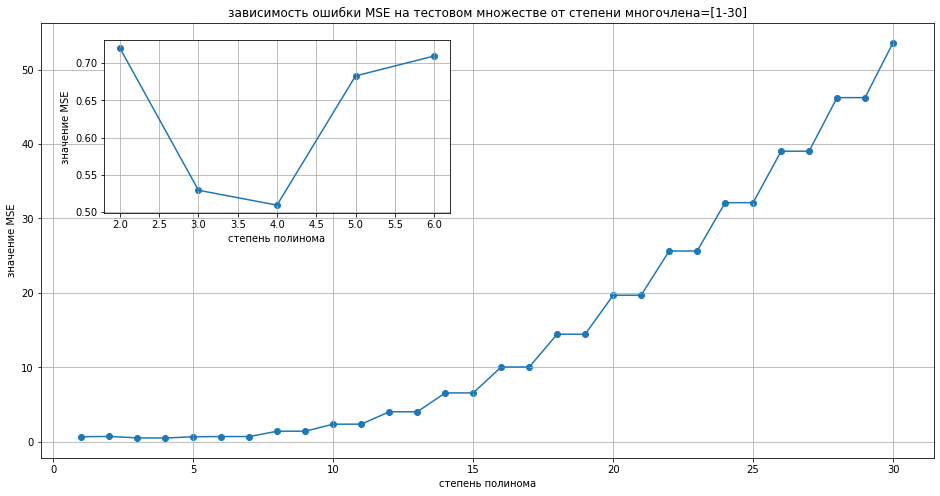

In [72]:
n_deg = 30
y_deg = []
# тестовые 10 точек x = np.linspace(-1, 1, 10)
# x100 = np.linspace(-1, 1, 100)
for i in range(1,n_deg+1):
  coefs = np.polyfit(x, y, deg = i)
  poly = np.poly1d(coefs)
  y_deg=np.append(y_deg, mean_squared_error(poly(x100), f(x100)))
plt.figure(figsize=(16, 8))
plt.scatter(np.arange(1,n_deg+1), y_deg,label=' MSE' )
plt.plot(np.arange(1,n_deg+1), y_deg)
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()
plt.title("зависимость ошибки MSE на тестовом множестве от степени многочлена=[1-30]")
plt.axes([.18, .55, .3, .3])
plt.scatter(np.arange(2,6+1), y_deg[1:6],label=' MSE' )
plt.plot(np.arange(2,6+1), y_deg[1:6])
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()
plt.show()

**(1 балл) Доп. задача 5:** как меняется график, если увеличивать количество точек в множестве, на котором мы подбираем многочлен?

Увеличение количества точек в train помогло уменьшить максимальное значение MSE. Для степени многочлена = 30
- при train = 10 точек MSE = 80 ⇒ в 80/0.15 = 533 раза больше, чем ошибка MSE при лучшем решении (степень = 3)
- при train = 100 точек MSE = 0.3 ⇒ в 0.3/0,01 = 30 раза больше, чем ошибка MSE при лучшем решении (степень = 3)
Обучаясь на большем количестве точек мы меньше ошибаемся.

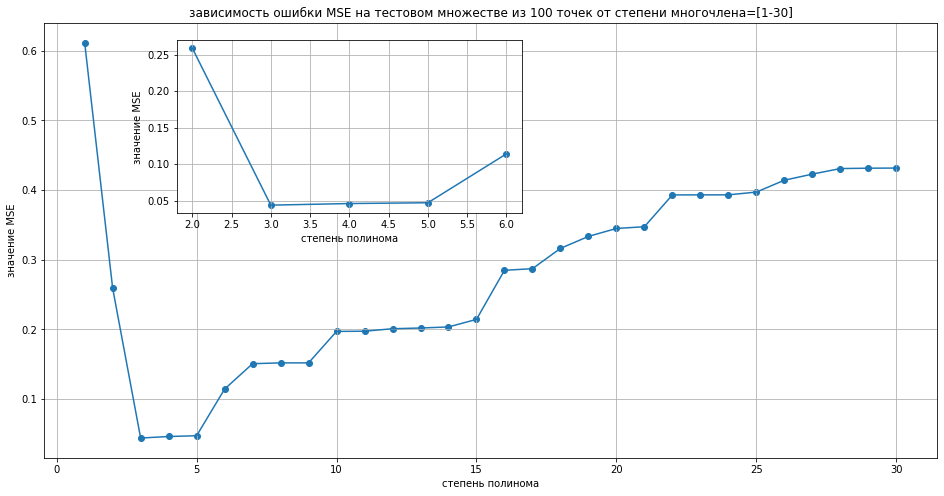

In [73]:
n_deg = 30
y_deg = []
x = np.linspace(-1, 1, 100) # увеличили train с 10 до 100 точек в интервале [-1:1]
y = f_real(x)
for i in range(1,n_deg+1):
  coefs = np.polyfit(x, y, deg = i)
  poly = np.poly1d(coefs)
  y_deg=np.append(y_deg, mean_squared_error(poly(x100), f(x100)))
plt.figure(figsize=(16, 8))
plt.scatter(np.arange(1,n_deg+1), y_deg,label=' MSE' )
plt.plot(np.arange(1,n_deg+1), y_deg)
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()
plt.title("зависимость ошибки MSE на тестовом множестве из 100 точек от степени многочлена=[1-30]")
plt.axes([.24, .55, .3, .3])
plt.scatter(np.arange(2,6+1), y_deg[1:6],label=' MSE' )
plt.plot(np.arange(2,6+1), y_deg[1:6])
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()
plt.show()

**(1 балл) Доп. задача 6:** проделайте все вышеописанное с функцией $f(x) = \frac{1}{1 + e^{-x}}$ на отрезке $[-3, 3]$. Как оптимальная степень зависит от количества точек, по которым вы подбираете многочлен?

1. Построить заданную функцию

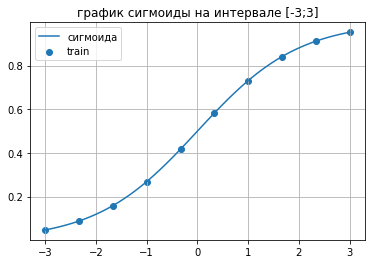

In [74]:
def sigmoid(x):
  return 1. / (1 + np.exp(-x))
x = np.linspace(-3, 3, 10) # train = 10 точек в интервале [-3:3]
x100 = np.linspace(-3, 3, 100) # для графика сигмоиды
y = sigmoid(x)
plt.scatter(x, sigmoid(x),label='train' )
plt.plot(x100, sigmoid(x100),label='сигмоида')
plt.grid()
plt.legend()
plt.title("график сигмоиды на интервале [-3;3]")
plt.show()

2. Взять 10 точек от -3 до 3 и приближать её полиномом разной степени, построить график ошибки

Многочлен степени = 9 приближает сигмоиду с меньшей ошибкой MSE = 3.44 *10^(-8)


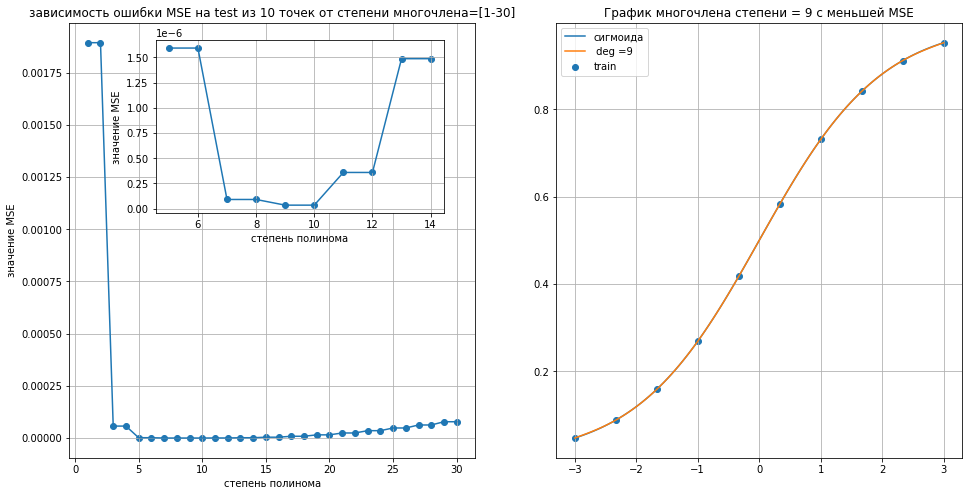

In [75]:
n_deg = 30
y_deg = []
for i in range(1,n_deg+1):
  coefs = np.polyfit(x, y, deg = i)
  poly = np.poly1d(coefs)
  y_deg=np.append(y_deg, mean_squared_error(poly(x100), sigmoid(x100)))
n_opt = 1+y_deg.argmin() # степень полинома с меньшей ошибкой
print("Многочлен степени = {} приближает сигмоиду с меньшей ошибкой MSE = {:2.2f} *10^(-8)".format(n_opt,pow(10,8)*y_deg.min()))
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(1,n_deg+1), y_deg,label=' MSE' )
plt.plot(np.arange(1,n_deg+1), y_deg)
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()
plt.title("зависимость ошибки MSE на test из 10 точек от степени многочлена=[1-30]")
plt.axes([.2, .55, .25, .3])
plt.scatter(np.arange(5,14+1), y_deg[4:14],label=' MSE' )
plt.plot(np.arange(5,14+1), y_deg[4:14])
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()

plt.subplot(1, 2, 2)
coefs_n = np.polyfit(x, y, deg = n_opt)
poly_n = np.poly1d(coefs_n)
plt.scatter(x, sigmoid(x),label='train' )
plt.plot(x100, sigmoid(x100),label='сигмоида')
plt.plot(x100, poly_n(x100),label=' deg ='+str(n_opt))
plt.legend()
plt.grid()
plt.title("График многочлена степени = "+str(n_opt)+" с меньшей MSE")
plt.show()

**Вывод 2**: многочлен 9 степени приближает функцию $f(x) = \frac{1}{1 + e^{-x}}$ на отрезке $[-3; 3]$ с меньшей ошибкой MSE = $3 \cdot 10^{-8}$. 

3. Взять 10 случайных точек от -3 до 3 и посмотреть ошибку на этих точках полиномиальных функций обученных по пункту 2 (т.е. взять тренировочные точки для обучения из пункта 2, а тестировать случайными точками) построить график.

Медианное значение ошибки на 999 наборах по 10 точек = 3.51 *10^(-8)


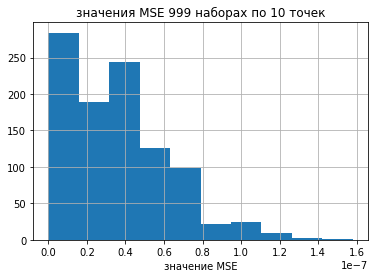

In [76]:
coefs = np.polyfit(x, y, deg = n_opt) # n_opt степень полинома с меньшей ошибкой
poly = np.poly1d(coefs)
n = 999
y_deg = []
for _ in range(n): # берем n случайных наборов по 10 точек из интервала [-3;3]
  x_i=(3+3)*np.random.random(10)-3
  y_deg=np.append(y_deg, mean_squared_error(poly(x_i), sigmoid(x_i)))
print("Медианное значение ошибки на {} наборах по 10 точек = {:2.2f} *10^(-8)".format(n,pow(10,8)*y_deg.mean()))
plt.hist(y_deg)
plt.xlabel('значение MSE')
plt.grid()
plt.title('значения MSE '+str(n)+' наборах по 10 точек')
plt.show()

**Вывод 3**: на 999 наборах по 10 точек медианное значение MSE = $3 \cdot 10^{-8}$, что соответсвует значению из предыдущего 2-го пункта. 

4. Добавить в функцию случайный шум и проделать пункты 2 и 3 для неё.


In [77]:
def sigmoid_real(x):
  return 1. / (1 + np.exp(-x))+ np.random.normal(0, 0.1, x.shape)
 
x = np.linspace(-3, 3, 10) # train = 10 точек в интервале [-3:3]
y = sigmoid_real(x) 

Многочлен степени = 5 приближает сигмоиду с меньшей ошибкой MSE = 0.01066 


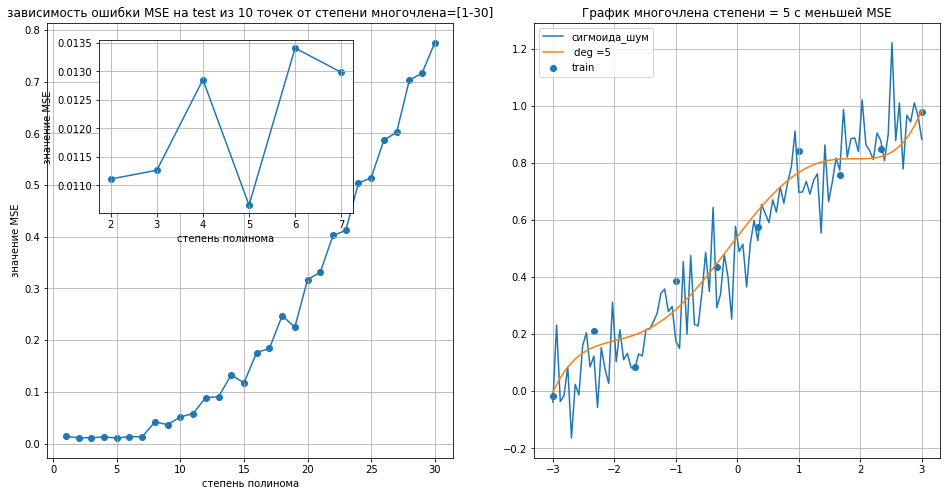

In [78]:
n_deg = 30
y_deg = []
for i in range(1,n_deg+1):
  coefs = np.polyfit(x, y, deg = i)
  poly = np.poly1d(coefs)
  y_deg=np.append(y_deg, mean_squared_error(poly(x100), sigmoid_real(x100)))
n_opt = 1+y_deg.argmin() # степень полинома с меньшей ошибкой
print("Многочлен степени = {} приближает сигмоиду с меньшей ошибкой MSE = {:2.5f} ".format(n_opt,y_deg.min()))
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(1,n_deg+1), y_deg,label=' MSE' )
plt.plot(np.arange(1,n_deg+1), y_deg)
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()
plt.title("зависимость ошибки MSE на test из 10 точек от степени многочлена=[1-30]")
plt.axes([.17, .55, .22, .3])
plt.scatter(np.arange(2,7+1), y_deg[1:7],label=' MSE' )
plt.plot(np.arange(2,7+1), y_deg[1:7])
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()

plt.subplot(1, 2, 2)
coefs_n = np.polyfit(x, y, deg = n_opt)
poly_n = np.poly1d(coefs_n)
plt.scatter(x, y,label='train' )
plt.plot(x100, sigmoid_real(x100),label='сигмоида_шум')
plt.plot(x100, poly_n(x100),label=' deg ='+str(n_opt))
plt.legend()
plt.grid()
plt.title("График многочлена степени = "+str(n_opt)+" с меньшей MSE")
plt.show()

Медианное значение ошибки на 999 наборах по 10 точек = 0.01220


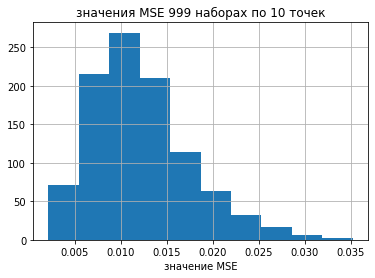

In [79]:
coefs = np.polyfit(x, y, deg = n_opt) # n_opt степень полинома с меньшей ошибкой
poly = np.poly1d(coefs)
n = 999
y_deg = []
for _ in range(n): # берем n случайных наборов по 10 точек из интервала [-3;3]
  x_i=(3+3)*np.random.random(10)-3
  y_deg=np.append(y_deg, mean_squared_error(poly(x_i), sigmoid_real(x_i)))
print("Медианное значение ошибки на {} наборах по 10 точек = {:2.5f}".format(n,y_deg.mean()))
plt.hist(y_deg)
plt.xlabel('значение MSE')
plt.grid()
plt.title('значения MSE '+str(n)+' наборах по 10 точек')
plt.show()

**Вывод 4**: сигмоиду с шумом тоже можно приблизить полиномом. В этом случае ошибка получается больше на несколько порядков, по сравнению с сигмоидой без шума. На 999 наборах по 10 точек медианное значение MSE получается больше, чем на train (на котором мы нашли оптимальную стпень многочлена для приближения к сигмоиде с шумом)

5. Увеличить количество тренировочных(только тренировочных) точек с 10 например до 20 40 60. И проделать пункты 2 и 3, для этих сэмплов

In [80]:
x = np.linspace(-3, 3, 40) # train = 20 точек в интервале [-3:3]
y = sigmoid_real(x)
x100 = np.linspace(-3, 3, 100) # для графика сигмоиды 

Многочлен степени = 7 приближает сигмоиду с меньшей ошибкой MSE = 0.00924 


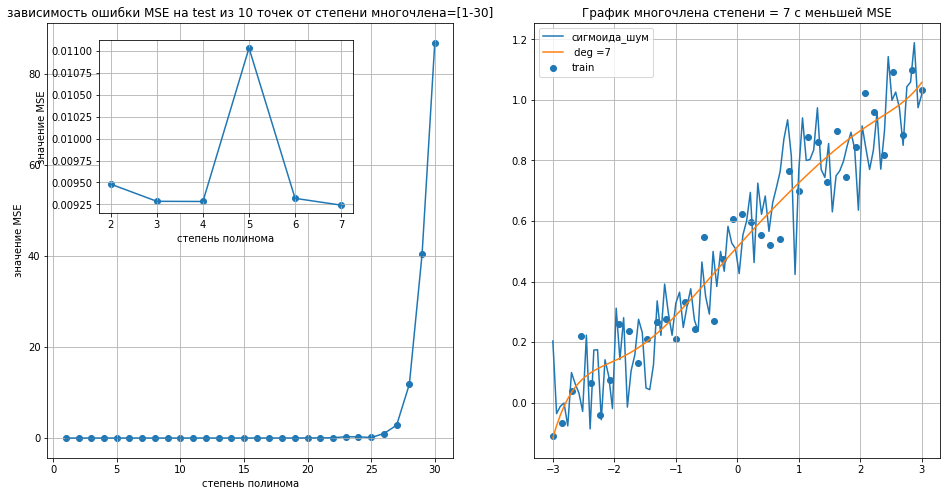

In [81]:
n_deg = 30
y_deg = []
for i in range(1,n_deg+1):
  coefs = np.polyfit(x, y, deg = i)
  poly = np.poly1d(coefs)
  y_deg=np.append(y_deg, mean_squared_error(poly(x100), sigmoid_real(x100)))
n_opt = 1+y_deg.argmin() # степень полинома с меньшей ошибкой
print("Многочлен степени = {} приближает сигмоиду с меньшей ошибкой MSE = {:2.5f} ".format(n_opt,y_deg.min()))
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(np.arange(1,n_deg+1), y_deg,label=' MSE' )
plt.plot(np.arange(1,n_deg+1), y_deg)
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()
plt.title("зависимость ошибки MSE на test из 10 точек от степени многочлена=[1-30]")
plt.axes([.17, .55, .22, .3])
plt.scatter(np.arange(2,7+1), y_deg[1:7],label=' MSE' )
plt.plot(np.arange(2,7+1), y_deg[1:7])
plt.xlabel('степень полинома')
plt.ylabel('значение MSE')
plt.grid()

plt.subplot(1, 2, 2)
coefs_n = np.polyfit(x, y, deg = n_opt)
poly_n = np.poly1d(coefs_n)
plt.scatter(x, y,label='train' )
plt.plot(x100, sigmoid_real(x100),label='сигмоида_шум')
plt.plot(x100, poly_n(x100),label=' deg ='+str(n_opt))
plt.legend()
plt.grid()
plt.title("График многочлена степени = "+str(n_opt)+" с меньшей MSE")
plt.show()

Медианное значение ошибки на 999 наборах по 10 точек = 0.01100


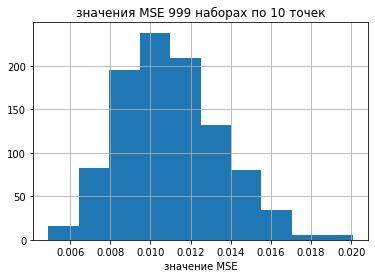

In [82]:
coefs = np.polyfit(x, y, deg = n_opt) # n_opt степень полинома с меньшей ошибкой
poly = np.poly1d(coefs)
n = 999
y_deg = []
for _ in range(n): # берем n случайных наборов по 40 точек из интервала [-3;3]
  x_i=(3+3)*np.random.random(40)-3
  y_deg=np.append(y_deg, mean_squared_error(poly(x_i), sigmoid_real(x_i)))
print("Медианное значение ошибки на {} наборах по 10 точек = {:2.5f}".format(n,y_deg.mean()))
plt.hist(y_deg)
plt.xlabel('значение MSE')
plt.grid()
plt.title('значения MSE '+str(n)+' наборах по 10 точек')
plt.show()

**Вывод 5**: уменьшение точек в train не помогло уменьшить ошибку MSE для лучшего приближения сигмоиды с шумом. Странно, но получается, что в данном случае можно обуччатся на 10 точнах и на 40, а ответ получим +/- одинаковый.

6. Сделать выводы.

Медианное значение  степени полинома = 3.21212 (train = равномерные 10 точек)
Медианное значение  степени полинома = 2.03030 (train = случайные 10 точек)


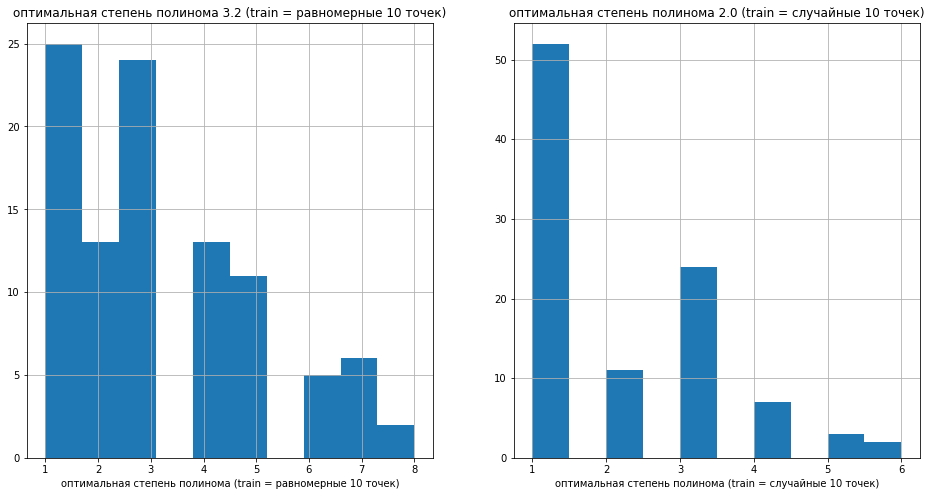

In [83]:
n_opt_lin_mass = []
n_opt_rand_mass = []
for _ in range(99): # берем n случайных наборов по 10 точек из интервала [-3;3]
  x_i_rand=(3+3)*np.random.random(10)-3
  x_i_lin=np.linspace(-3, 3, 10) 
  y_i_rand = sigmoid_real(x_i_rand)
  y_i_lin = sigmoid_real(x_i_lin)
  n_deg = 30
  y_deg_lin = []
  y_deg_rand = []
  for i in range(1,n_deg+1): # ищем лучшую степень полинома
    coefs_rand = np.polyfit(x_i_rand, y_i_rand, deg = i)
    poly_rand = np.poly1d(coefs_rand)
    coefs_lin = np.polyfit(x_i_lin, y_i_lin, deg = i)
    poly_lin = np.poly1d(coefs_lin)
    y_deg_lin=np.append(y_deg_lin, mean_squared_error(poly_lin(x100), sigmoid_real(x100)))
    y_deg_rand=np.append(y_deg_rand, mean_squared_error(poly_rand(x100), sigmoid_real(x100)))
  n_opt_lin = 1+y_deg_lin.argmin() # степень полинома с меньшей ошибкой (равномерные 10 точек)
  n_opt_rand = 1+y_deg_rand.argmin() # степень полинома с меньшей ошибкой (случайные 10 точек)
  n_opt_lin_mass=np.append(n_opt_lin_mass, n_opt_lin)
  n_opt_rand_mass=np.append(n_opt_rand_mass, n_opt_rand)
print("Медианное значение  степени полинома = {:2.5f} (train = равномерные 10 точек)".format(n_opt_lin_mass.mean()))
print("Медианное значение  степени полинома = {:2.5f} (train = случайные 10 точек)".format(n_opt_rand_mass.mean()))
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.hist(n_opt_lin_mass)
plt.xlabel('оптимальная степень полинома (train = равномерные 10 точек)')
plt.grid()
plt.title('оптимальная степень полинома '+str(np.round(n_opt_lin_mass.mean(),1))+' (train = равномерные 10 точек)')
plt.subplot(1, 2, 2)
plt.hist(n_opt_rand_mass)
plt.xlabel('оптимальная степень полинома (train = случайные 10 точек)')
plt.grid()
plt.title('оптимальная степень полинома '+str(np.round(n_opt_rand_mass.mean(),1))+' (train = случайные 10 точек)')
plt.show()

**Вывод 6**: в итоге мне стало интересно полином какой степени будет лучшим для нашей сигмоиды с шумом? Поэтому возьмем 99 наборов по 10 точек и на каждом выберем оптимальныу степень. Получилось медианное значение оптимальных степеней полинома = 2 (обучаемся на 10 случано расположенных точках) и 3 (обучаемся на 10 равномерно расположенных точках). Значит нашу сигмоиду с шумом можно приблизить параболой или кубической параболой. Более высокие степени дают большую ошибку, следовательно излишни.

## 7. Линейная регрессия на реальных данных

До этого мы учились приближать одномерную функцию многочленом. Каждая точка имела ровно один признак - коодинату $x$.

Тем не менее, чаще всего в машинном обучении признаков гораздо больше. Возьмем какой-нибудь реальный датасет.

In [84]:
# https://drive.google.com/file/d/13kQUcl-N3ag6NXEm-QWjdUiuHO4-LOxb/view?usp=sharing
!gdown --id 13kQUcl-N3ag6NXEm-QWjdUiuHO4-LOxb

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13kQUcl-N3ag6NXEm-QWjdUiuHO4-LOxb
To: /content/Advertising.csv
100% 5.17k/5.17k [00:00<00:00, 5.70MB/s]


In [85]:
import pandas as pd
data = pd.read_csv('Advertising.csv', index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


Целевая переменная:

sales - продажи такого-то товара (тысячи штук)

In [86]:
# Размеры датасета
data.shape

(200, 4)

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [88]:
data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


Признаков немного, поэтому давайте попробуем визуализиовать зависимость целевой переменной от каждого из признаков.

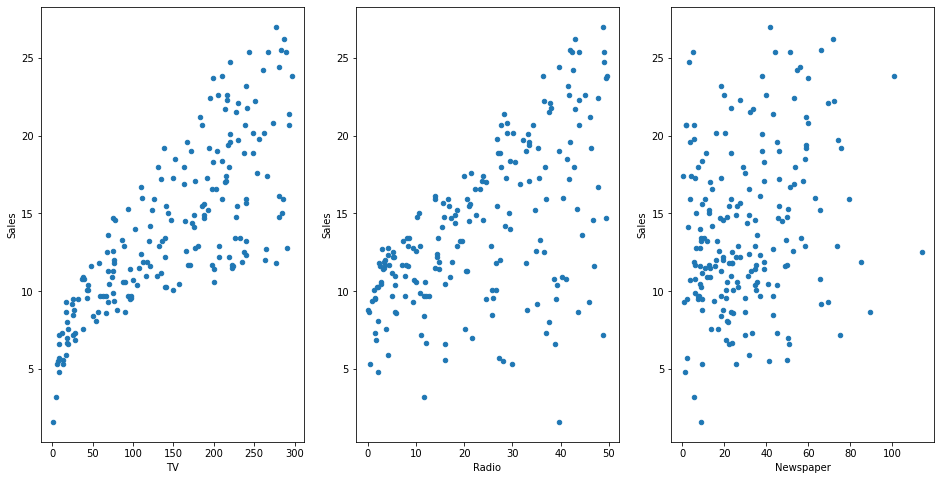

In [89]:
fig, axs = plt.subplots(1, 3,)
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])
plt.show()

В датасете показаны результаты продаж разных товаров в зависимости от ресурсов (тысяч долларов), которые вложили в различные средства распространения информации:
* TV - реклама по телевизору
* radio - на радио
* newspapers - в газетах

**(0.5 балла) Обязательное задание 4:** нарисуйте график зависимости ошибки на тестовом множестве от коэффициента регуляризации. При какой степени ошибка минимальна?

**(0.5 балла) Обязательное задание 5:** Сделайте то же самое для L2-регуляризации:

Минимальная ошибка MSE при lambda = 1.90 (L1)
Минимальная ошибка MSE при lambda = 9.90 (L2)


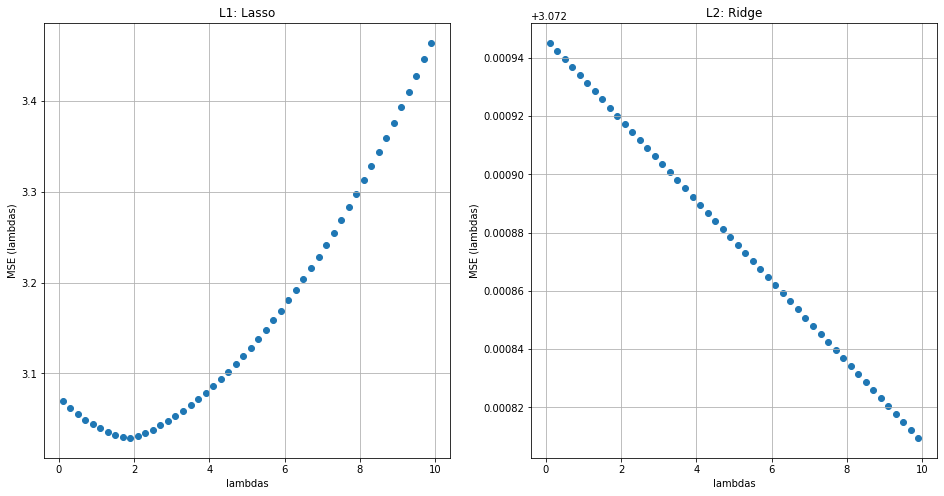

In [90]:
lambdas = np.arange(0.1, 10.0, 0.2) # возможные lambda

from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score
X = data.drop("Sales", axis=1)
y = data["Sales"]

lambda_errors_L1 = [] 
lambda_errors_L2 = [] 
# Проходим по всем лямбдам и записываем ошибки на test
for val in lambdas:
  errors_L1 = -cross_val_score(Lasso(alpha=val).fit(X, y) , X, y, cv=5, scoring='neg_mean_squared_error')
  lambda_errors_L1=np.append(lambda_errors_L1,np.mean(errors_L1))
  errors_L2 = -cross_val_score(Ridge(alpha=val).fit(X, y) , X, y, cv=5, scoring='neg_mean_squared_error')
  lambda_errors_L2=np.append(lambda_errors_L2,np.mean(errors_L2))
print("Минимальная ошибка MSE при lambda = {:2.2f} (L1)".format(lambdas[lambda_errors_L1.argmin()]))
print("Минимальная ошибка MSE при lambda = {:2.2f} (L2)".format(lambdas[lambda_errors_L2.argmin()]))
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(lambdas, lambda_errors_L1 )
plt.xlabel('lambdas')
plt.ylabel("MSE (lambdas)")
plt.grid()
plt.title("L1: Lasso")
plt.subplot(1, 2, 2)
plt.scatter(lambdas, lambda_errors_L2 )
plt.xlabel('lambdas')
plt.ylabel("MSE (lambdas)")
plt.grid()
plt.title("L2: Ridge")
plt.show()

Если всё было правильно, то данные манипуляции помогут немного улучшить качество вашей модели. Это поднимет вас на несколько мест в соревнованиях, или вашему работодателю даст побольше прибыли.

# Основное домашнее задание (6 баллов + гешефт за улучшения)

In [91]:
# https://drive.google.com/file/d/1dXl0DeoYG1mkXya6mDpaY0NhbcbI17Nu/view?usp=sharing
! gdown --id 1dXl0DeoYG1mkXya6mDpaY0NhbcbI17Nu

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1dXl0DeoYG1mkXya6mDpaY0NhbcbI17Nu
To: /content/diabetes.data.csv
100% 18.5k/18.5k [00:00<00:00, 25.7MB/s]


Для домашнего задания вы используете другой датасет.

In [92]:
data = pd.read_csv('diabetes.data.csv', sep='\t')
data.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


В датасете приводится информация о пациентах и их состоянии при заболевании диабетом. Описание признаков можно прочитать [здесь](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html). Колонка Y - целевая переменная:

In [93]:
target = 'Y'
X = data.drop([target], axis=1)
y = data[target]

X.shape, y.shape

((442, 10), (442,))

**Ваша задача** - провести то же исследование, что и в датасете в самом начале (Sales ~ TV, Radio, Newspaper). В итоге, нужно получить модель линейной регрессии, качество которой надо вывести с помощью cross_val_score с метрикой MSE (тоже самое в общем).

**Целевая метрика - MSE**

За каждое достойное улучшение качества на cross_val_score будут доп. баллы. Не забудьте описать, что использовали, что получилось и нет, а также попробуйте понять почему. Побольше гуглите. 

Возможные улучшения:
* Нормализация данных: вычитаем из каждой колонки её среднее и делим на стандартное отклонение.
* Пробуйте убрать ненужные признаки.
* Можно перемножать некоторые признаки.
* Погуглите что-то вроде "improve linear regression".

В общем, представьте, что вы работаете датасаентистом, получаете *300K bucks*, а вам сказали, что нужно как можно лучше уметь предсказывать такие данные.

В датасете данные 442 пациентов:

1.   AGE - возраст
2.   SEX - пол
3.   BMI - индекс массы тела
4.   BP - среднее кровяное давление
5.   S1 S2 S3 S4 S5 S6 - шесть измерений сыворотки крови
6.   Y - количественная мера прогрессирования заболевания через год после начала исследований

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGE     442 non-null    int64  
 1   SEX     442 non-null    int64  
 2   BMI     442 non-null    float64
 3   BP      442 non-null    float64
 4   S1      442 non-null    int64  
 5   S2      442 non-null    float64
 6   S3      442 non-null    float64
 7   S4      442 non-null    float64
 8   S5      442 non-null    float64
 9   S6      442 non-null    int64  
 10  Y       442 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


Таблица заполена полностью, пропущенных значений нет.

Все параметры числовые.

In [95]:
data.describe()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


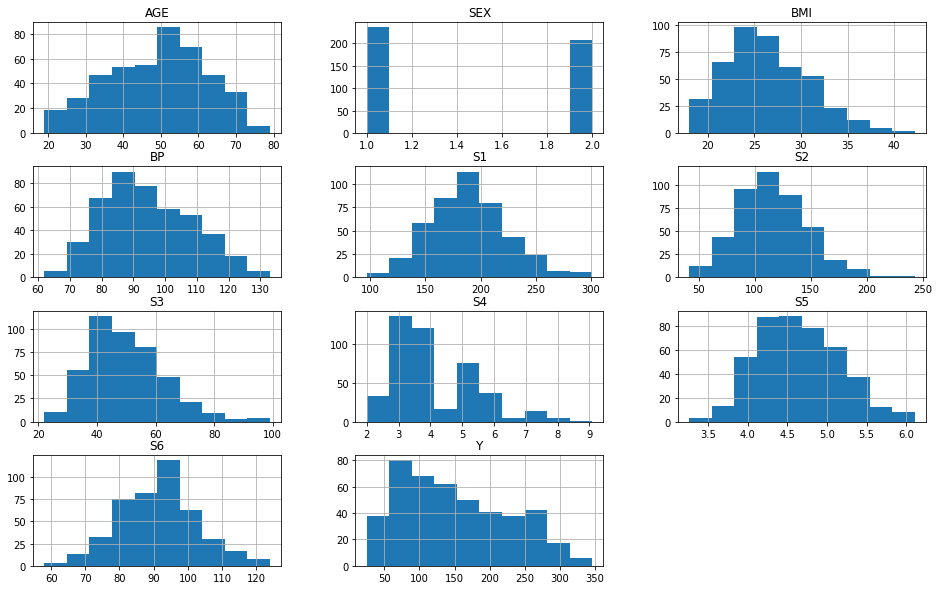

In [96]:
data.hist(figsize=(16,10))
None

Посмотрим на графики корреляции всех 10 признаков между собой. 

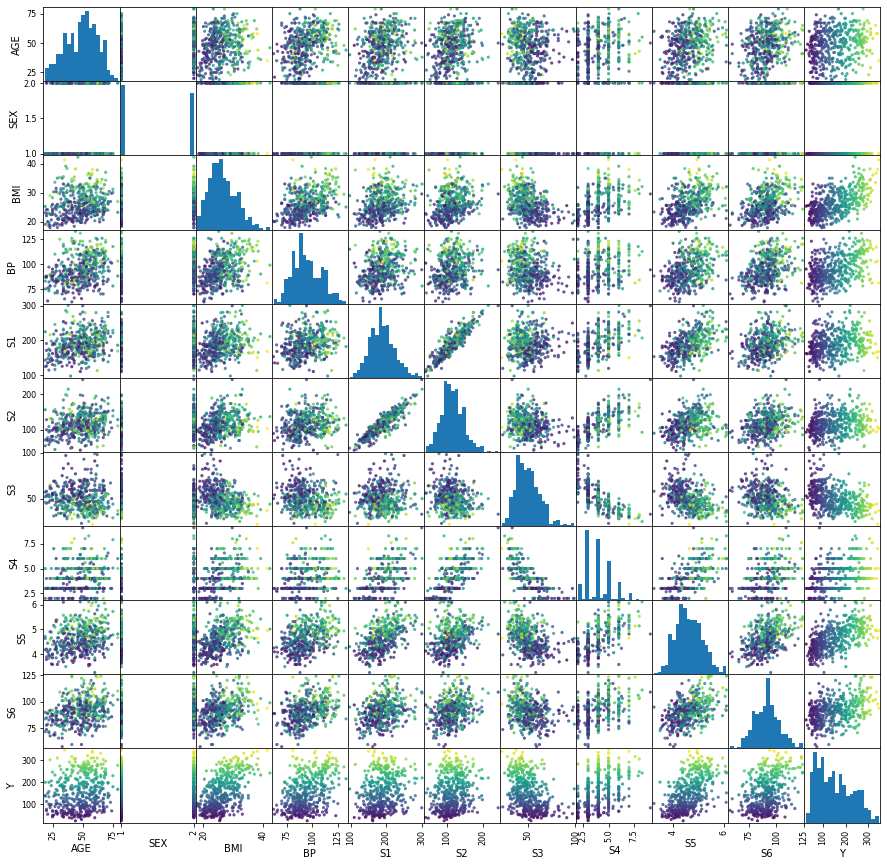

In [97]:
pd.plotting.scatter_matrix(data, c=data['Y'], figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=10, alpha=.8)
None

Посмотрим на таблицу корреляции всех 10 признаков между собой. 

In [98]:
data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
AGE,1.00,0.17,0.19,0.34,0.26,0.22,-0.08,0.20,0.27,0.30,0.19
SEX,0.17,1.00,0.09,0.24,0.04,0.14,-0.38,0.33,0.15,0.21,0.04
BMI,0.19,0.09,1.00,0.40,0.25,0.26,-0.37,0.41,0.45,0.39,0.59
BP,0.34,0.24,0.40,1.00,0.24,0.19,-0.18,0.26,0.39,0.39,0.44
S1,0.26,0.04,0.25,0.24,1.00,0.90,0.05,0.54,0.52,0.33,0.21
S2,0.22,0.14,0.26,0.19,0.90,1.00,-0.20,0.66,0.32,0.29,0.17
S3,-0.08,-0.38,-0.37,-0.18,0.05,-0.20,1.00,-0.74,-0.40,-0.27,-0.39
S4,0.20,0.33,0.41,0.26,0.54,0.66,-0.74,1.00,0.62,0.42,0.43
S5,0.27,0.15,0.45,0.39,0.52,0.32,-0.40,0.62,1.00,0.46,0.57
S6,0.30,0.21,0.39,0.39,0.33,0.29,-0.27,0.42,0.46,1.00,0.38


Отрицательные значения показывают обратную зависимость между признаками. Прямая или обратная - сейчас это не принципиально, главное, что зависимость. Поставим модуль занчений, что бы палитра стала от нуля и это помогло увидеть глазами более красные ячейки (кроме диагональных) - зависимые признаки.

In [99]:
data.corr().abs().style.background_gradient(cmap='coolwarm').set_precision(2)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
AGE,1.00,0.17,0.19,0.34,0.26,0.22,0.08,0.20,0.27,0.30,0.19
SEX,0.17,1.00,0.09,0.24,0.04,0.14,0.38,0.33,0.15,0.21,0.04
BMI,0.19,0.09,1.00,0.40,0.25,0.26,0.37,0.41,0.45,0.39,0.59
BP,0.34,0.24,0.40,1.00,0.24,0.19,0.18,0.26,0.39,0.39,0.44
S1,0.26,0.04,0.25,0.24,1.00,0.90,0.05,0.54,0.52,0.33,0.21
S2,0.22,0.14,0.26,0.19,0.90,1.00,0.20,0.66,0.32,0.29,0.17
S3,0.08,0.38,0.37,0.18,0.05,0.20,1.00,0.74,0.40,0.27,0.39
S4,0.20,0.33,0.41,0.26,0.54,0.66,0.74,1.00,0.62,0.42,0.43
S5,0.27,0.15,0.45,0.39,0.52,0.32,0.40,0.62,1.00,0.46,0.57
S6,0.30,0.21,0.39,0.39,0.33,0.29,0.27,0.42,0.46,1.00,0.38


На основании таблицы корреляций делаем выводы:
*   Y не зависит от пола, corr = 0.04 маленькая. Поэтому удалим SEX из списка признаков для линейной регресиии
*   Y слабо зависит от возраста, corr = 0.19. Надо проверить уменьшится ли ошибка, если убрать из списка признаков для линейной регресиии AGE
*   corr(S1, S2) = 0.9. Корреляция высокая, вероятнее всего они линейно зависимы. Наверное один признак получается из другого. Поэтому удалим один из них из списка признаков для линейной регресиии. Удалим S2.
*   corr(S3, S4) = 0.74. Корреляция тоже большая, вероятнее всего они линейно зависимы. Надо проверить уменьшится ли ошибка, если убрать из списка признаков для линейной регресиии S3 или S4. На графике корреляции S4 странно выглядит, как будто в определенные дни задавали константные значения, т.е S4 не зависит от других признаков.
*   У признаков BMI, BP, S3, S4, S5, S6 корреляция с Y больше 0.38, поэтому думаю, что они важны. Признаки AGE, S1 слабо коррелируют с Y, поэтому надо проверить уменьшится ли ошибка, если убрать их из списка признаков для линейной регресиии


Разделим датасет на train и test перед нормализацией, чтобы в train не попала информация о test.

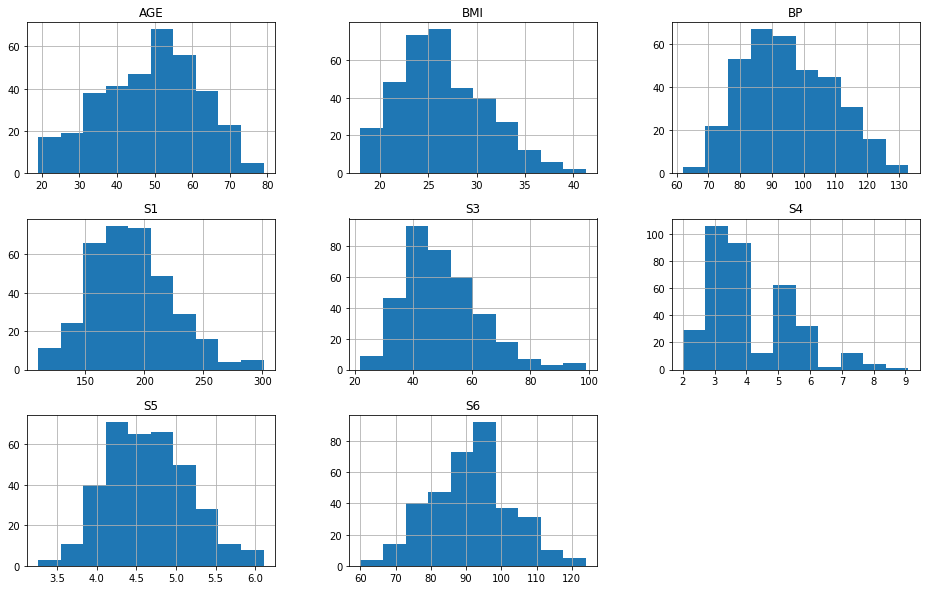

In [100]:
X = data.drop(columns=['Y','SEX','S2'])
name_column = X.columns.tolist()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data['Y'], test_size=0.2)
X_train.hist(figsize=(16,10))
None

Нормализуем данные в каждом из столбцов train, что бы они получились одного порядка. И отдельно нормализуем test. Для самопроветки визуально сравниваем гистограммы. Они одинаковые, значит все верно.

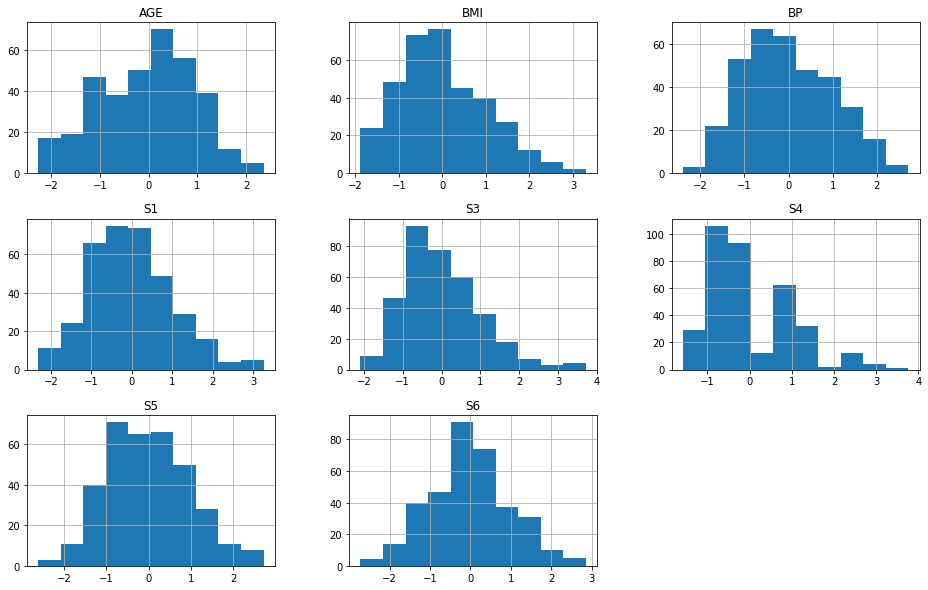

In [101]:
from sklearn.preprocessing import StandardScaler

pca = StandardScaler()
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

# переписываем навания столбцов, которые потерялить после нормализации
X_train = pd.DataFrame(data = X_train, columns=name_column) 
X_test = pd.DataFrame(data = X_test, columns=name_column)  

X_train.hist(figsize=(16,10))
None

Построим линейную регрессию на train без призаков SEX, S2. И посмотрим ошибку на test

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
def print_metrics(y_preds, y):
    print(f'R^2: {r2_score(y_preds, y)}')
    print(f'MSE: {mean_squared_error(y_preds, y)}')

In [103]:
lr_SEX_S2 = LinearRegression()
lr_SEX_S2.fit(X_train, y_train)

print_metrics(lr_SEX_S2.predict(X_test), y_test)
for column, coef in zip(name_column, lr_SEX_S2.coef_):
    print("Коэффициент для {} = {}".format(column, coef)) 

R^2: -0.18533075185614023
MSE: 3602.84567789917
Коэффициент для AGE = -0.7502720935266406
Коэффициент для BMI = 28.214405513953576
Коэффициент для BP = 13.273678248819348
Коэффициент для S1 = -10.786553923182312
Коэффициент для S3 = -3.3098017369309565
Коэффициент для S4 = 4.846692493266511
Коэффициент для S5 = 27.1037148613035
Коэффициент для S6 = 1.559550784454668


Оставим текущее деление датасета на train и test. Нормализацию сохраним.

Теперь попробем удалить признак AGE и посмотрим на ошибку

In [104]:
X_train_AGE = X_train.drop(columns=['AGE'])
X_test_AGE = X_test.drop(columns=['AGE'])
name_column_AGE = X_train_AGE.columns.tolist()

lr_SEX_S2_AGE = LinearRegression()
lr_SEX_S2_AGE.fit(X_train_AGE, y_train)

print_metrics(lr_SEX_S2_AGE.predict(X_test_AGE), y_test)
for column, coef in zip(name_column_AGE, lr_SEX_S2_AGE.coef_):
    print("Коэффициент для {} = {}".format(column, coef)) 

R^2: -0.1865702981887989
MSE: 3606.1143193315293
Коэффициент для BMI = 28.188844784869914
Коэффициент для BP = 13.104885826027804
Коэффициент для S1 = -10.845475430659715
Коэффициент для S3 = -3.3294499711689873
Коэффициент для S4 = 4.862075709497815
Коэффициент для S5 = 27.063911171092762
Коэффициент для S6 = 1.4442002124795383


Ошибки $R^2$ и MSE одинаковые и с признаком AGE и без него. Поэтому оставим его.

Посмотрим, что нам предложит занулить L1-регуляризация: AGE, S4, S6

In [105]:
reg = Lasso( ).fit(X_train, y_train)

print_metrics(reg.predict(X_test), y_test)
print("Сдвиг={}".format(reg.intercept_))
for column, coef in zip(X_train.columns, reg.coef_):
    print("Коэффициент для {}={}".format(column, coef))


R^2: -0.25620839578948096
MSE: 3580.4069748264315
Сдвиг=156.56657223796037
Коэффициент для AGE=-0.0
Коэффициент для BMI=27.590829600215496
Коэффициент для BP=12.37220387785716
Коэффициент для S1=-5.882242318210604
Коэффициент для S3=-7.1747245541811155
Коэффициент для S4=0.0
Коэффициент для S5=25.77886585563733
Коэффициент для S6=0.8553524925431053


Удалим столбцы AGE, S4, S6 по рекомендации L1-регуляризации. Построим линейную регрессию на оставшихся признаках

In [106]:
X_train_SEX_S2_AGE_S4_S6 = X_train.drop(columns=['AGE','S4','S6'])
X_test_SEX_S2_AGE_S4_S6 = X_test.drop(columns=['AGE','S4','S6'])
name_column_SEX_S2_AGE_S4_S6 = X_train_SEX_S2_AGE_S4_S6.columns.tolist()

lr_SEX_S2_AGE_S4_S6 = LinearRegression()
lr_SEX_S2_AGE_S4_S6.fit(X_train_SEX_S2_AGE_S4_S6, y_train)

print_metrics(lr_SEX_S2_AGE_S4_S6.predict(X_test_SEX_S2_AGE_S4_S6), y_test)
for column, coef in zip(name_column_SEX_S2_AGE_S4_S6, lr_SEX_S2_AGE_S4_S6.coef_):
    print("Коэффициент для {} = {}".format(column, coef)) 

R^2: -0.19906461449737467
MSE: 3615.749340220319
Коэффициент для BMI = 28.331877770345724
Коэффициент для BP = 13.174525011686544
Коэффициент для S1 = -7.9262458634110455
Коэффициент для S3 = -7.191767895488293
Коэффициент для S5 = 27.579043537901796


Ошибки $R^2$ и MSE одинаковые и с признаками AGE, S4, S6 и без них. Значит они все-таки не существенны. Тогда возьмем последнюю линейную регрессиию (без признаков SEX_S2_AGE_S4_S6), которая построена на пяти признаках BMI, BP, S1, S3, S5.

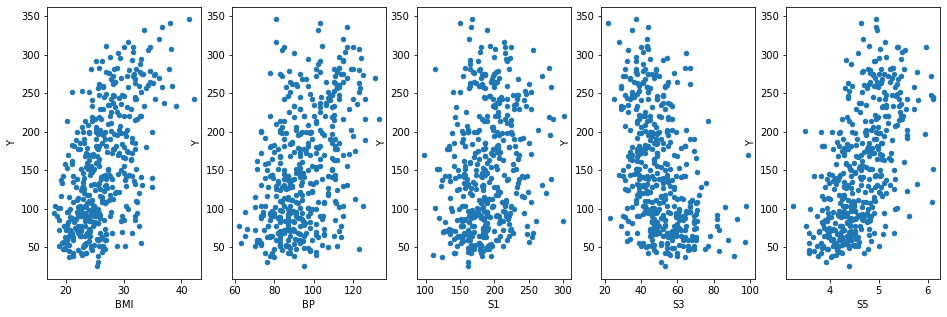

In [107]:
fig, axs = plt.subplots(1, 5,)
data.plot(kind='scatter', x='BMI', y='Y', ax=axs[0], figsize=(16, 5))
data.plot(kind='scatter', x='BP', y='Y', ax=axs[1])
data.plot(kind='scatter', x='S1', y='Y', ax=axs[2])
data.plot(kind='scatter', x='S3', y='Y', ax=axs[3])
data.plot(kind='scatter', x='S5', y='Y', ax=axs[4])
plt.show()

Исходя из коэффициентов линейной регрессии lr_SEX_S2_AGE_S4_S6 и точечных графиков: Y напрямую зависит от признаков BMI, BP, S5 и обратно от S1, S3.Получается, чем выше индекс массы тела, среднее кровяное давление, S5 (измерение сывортки крови), и чем ниже S1 и S3 (измерение сывортки крови), то больше мера Y прогрессирования заболевания через год после начала исследований. Возраст, пол, S2, S4, S6 (измерение сывортки крови) не влияют на развитие болезни.

Посчитаем ошибки $R^2$ и MSE в результате кросс-валидации - это и будет ответом задачи

In [108]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
scorr = cross_validate(lr_SEX_S2_AGE_S4_S6, X_part, data['Y'], cv=10, 
               scoring={'r2_score': make_scorer(r2_score), 
                        'mean_squared_error': make_scorer(mean_squared_error)})
scorr
print('R^2_teat : ',np.mean(scorr['test_r2_score']))
print('MSE_test : ',np.mean(scorr['test_mean_squared_error']))
scorr

R^2_teat :  0.45415977642478733
MSE_test :  3036.3232761413556


{'fit_time': array([0.00492334, 0.00350857, 0.00343585, 0.00268078, 0.00213933,
        0.00199747, 0.00198054, 0.0020144 , 0.00197554, 0.0021379 ]),
 'score_time': array([0.00302315, 0.00305557, 0.00317383, 0.00227308, 0.00183415,
        0.00184298, 0.00174546, 0.00193381, 0.00181365, 0.00177717]),
 'test_mean_squared_error': array([2705.15416554, 3008.99845179, 3491.38104562, 2862.86046043,
        3589.89875689, 2649.74682939, 3715.50990782, 2279.94895165,
        4259.18619344, 1800.54799883]),
 'test_r2_score': array([0.52613631, 0.19351155, 0.35750528, 0.60770417, 0.25881061,
        0.65118683, 0.41513243, 0.43572914, 0.41567808, 0.68020337])}

После кросс-варидации получили R2 = 0,44. Думаю, что это много, т.к. на предыдущих моделях на этом датасете получали R2 около 0,2. Как это исправить пока не понимаю, не вижу где ошибаюсь. (лекцию 8_Feature-инжиниринг еще не смотрела, может после нее найду решение)

MSE test < MSE trai, поэтому это не переобучение



In [52]:
# pip install drawdata

In [53]:
# from drawdata import draw_scatter
# draw_scatter()